In [1]:
import os
import folium

print(folium.__version__)

0.9.1


# Introduction

In this notebook we'll make a choropleth with a timeslider. We'll use my branched version of `folium`, which contains a plugin with a class called `TimeDynamicGeoJson`.

The class needs at least two arguments to be instantiated. 

1. A string-serielized geojson containing all the features (i.e., the areas)
2. A dictionary with the following structure:

```python
styledict = {
    '0': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        },
    ...,
    'n': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        }
}
```

In the above dictionary, the keys are the feature-ids.

Using both color and opacity gives us the ability to simultaneously visualize two features on the choropleth. I typically use color to visualize the main feature (like, average height) and opacity to visualize how many measurements were in that group.

## Loading the features
We use `geopandas` to load a dataset containing the boundaries of all the countries in the world.

In [3]:
import geopandas as gpd


assert 'naturalearth_lowres' in gpd.datasets.available
datapath = gpd.datasets.get_path('naturalearth_lowres')
gdf = gpd.read_file(datapath)

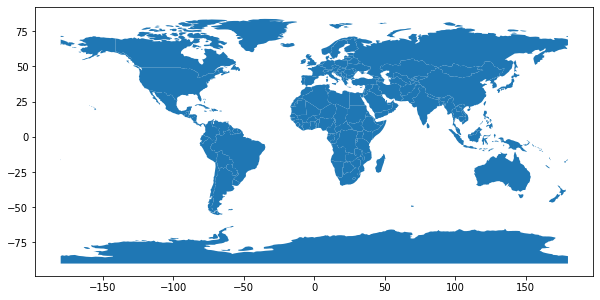

In [5]:
%matplotlib inline

ax = gdf.plot(figsize=(10, 10))

The `GeoDataFrame` contains the boundary coordinates, as well as some other data such as estimated population.

In [6]:
gdf.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


## Creating the style dictionary
Now we generate time series data for each country.  

Data for different areas might be sampled at different times, and `TimeDynamicGeoJson` can deal with that. This means that there is no need to resample the data, as long as the number of datapoints isn't too large for the browser to deal with.  

To simulate that data is sampled at different times we random sample data for `n_periods` rows of data and then pick without replacing `n_sample` of those rows. 

In [17]:
import pandas as pd


n_periods, n_sample = 48, 40

assert n_sample < n_periods

datetime_index = pd.date_range('2016-1-1', periods=n_periods, freq='M')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')

dt_index

Index(['1454198400', '1456704000', '1459382400', '1461974400', '1464652800',
       '1467244800', '1469923200', '1472601600', '1475193600', '1477872000',
       '1480464000', '1483142400', '1485820800', '1488240000', '1490918400',
       '1493510400', '1496188800', '1498780800', '1501459200', '1504137600',
       '1506729600', '1509408000', '1512000000', '1514678400', '1517356800',
       '1519776000', '1522454400', '1525046400', '1527724800', '1530316800',
       '1532995200', '1535673600', '1538265600', '1540944000', '1543536000',
       '1546214400', '1548892800', '1551312000', '1553990400', '1556582400',
       '1559260800', '1561852800', '1564531200', '1567209600', '1569801600',
       '1572480000', '1575072000', '1577750400'],
      dtype='object')

In [18]:
import numpy as np


styledata = {}

for country in gdf.index:
    df = pd.DataFrame(
        {'color': np.random.normal(size=n_periods),
         'opacity': np.random.normal(size=n_periods)},
        index=dt_index
    )
    df = df.cumsum()
    df.sample(n_sample, replace=False).sort_index()
    styledata[country] = df

Note that the geodata and random sampled data is linked through the feature_id, which is the index of the `GeoDataFrame`.

In [19]:
gdf.loc[0]

pop_est                                                  920938
continent                                               Oceania
name                                                       Fiji
iso_a3                                                      FJI
gdp_md_est                                                 8374
geometry      (POLYGON ((180 -16.06713266364245, 180 -16.555...
Name: 0, dtype: object

In [20]:
styledata.get(0).head()

,color,opacity
1454198400,-1.771729,-0.309845
1456704000,-1.366927,0.869050
1459382400,-2.179192,0.270797
1461974400,-2.581093,-0.722280
1464652800,-3.130717,-0.405503


We see that we generated two series of data for each country; one for color and one for opacity. Let's plot them to see what they look like. 

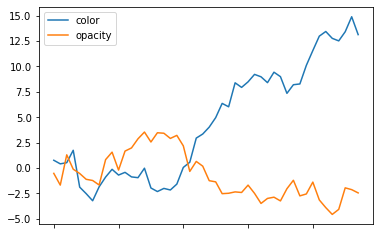

In [21]:
ax = df.plot()

Looks random alright. We want to map the column named `color` to a hex color. To do this we use a normal colormap. To create the colormap, we calculate the maximum and minimum values over all the timeseries. We also need the max/min of the `opacity` column, so that we can map that column into a range [0,1].

In [12]:
max_color, min_color, max_opacity, min_opacity = 0, 0, 0, 0

for country, data in styledata.items():
    max_color = max(max_color, data['color'].max())
    min_color = min(max_color, data['color'].min())
    max_opacity = max(max_color, data['opacity'].max())
    max_opacity = min(max_color, data['opacity'].max())

Define and apply maps: 

In [13]:
from branca.colormap import linear


cmap = linear.PuRd_09.scale(min_color, max_color)


def norm(x):
    return (x - x.min()) / (x.max() - x.min())


for country, data in styledata.items():
    data['color'] = data['color'].apply(cmap)
    data['opacity'] = norm(data['opacity'])

In [14]:
styledata.get(0).head()

,color,opacity
1454198400,#cea3cf,0.000000
1456704000,#cc9ccb,0.010257
1459382400,#cb9aca,0.069715
1461974400,#d086c1,0.280361
1464652800,#cb91c6,0.386777


Finally we use `pd.DataFrame.to_dict()` to convert each dataframe into a dictionary, and place each of these in a map from country id to data. 

In [15]:
styledict = {
    str(country): data.to_dict(orient='index') for
    country, data in styledata.items()
}

In [16]:
styledict

{'0': {'1454198400': {'color': '#cea3cf', 'opacity': 0.0},
  '1456704000': {'color': '#cc9ccb', 'opacity': 0.010257339495542233},
  '1459382400': {'color': '#cb9aca', 'opacity': 0.06971549132603938},
  '1461974400': {'color': '#d086c1', 'opacity': 0.28036133484962955},
  '1464652800': {'color': '#cb91c6', 'opacity': 0.38677661718835826},
  '1467244800': {'color': '#cf87c1', 'opacity': 0.4662707382111095},
  '1469923200': {'color': '#d972b7', 'opacity': 0.4267035998404059},
  '1472601600': {'color': '#e062ae', 'opacity': 0.4780986370464872},
  '1475193600': {'color': '#e15baa', 'opacity': 0.4794561045637966},
  '1477872000': {'color': '#da6fb5', 'opacity': 0.45932751416989376},
  '1480464000': {'color': '#cb90c5', 'opacity': 0.4526100651924824},
  '1483142400': {'color': '#ca93c7', 'opacity': 0.6023498687466479},
  '1485820800': {'color': '#d086c0', 'opacity': 0.7137029046910653},
  '1488240000': {'color': '#cb9aca', 'opacity': 0.6770345685104466},
  '1490918400': {'color': '#cb9bcb', '

In [23]:
gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,(POLYGON ((141.0002104025918 -2.60015105551566...
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
9,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...


In [22]:
gdf.to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"continent": "Oceania", "gdp_md_est": 8374.0, "iso_a3": "FJI", "name": "Fiji", "pop_est": 920938}, "geometry": {"type": "MultiPolygon", "coordinates": [[[[180.0, -16.067132663642447], [180.0, -16.555216566639196], [179.36414266196414, -16.801354076946883], [178.72505936299711, -17.01204167436804], [178.59683859511713, -16.639150000000004], [179.0966093629971, -16.433984277547403], [179.4135093629971, -16.379054277547404], [180.0, -16.067132663642447]]], [[[178.12557, -17.50481], [178.3736, -17.33992], [178.71806, -17.62846], [178.55271, -18.15059], [177.93266000000003, -18.28799], [177.38146, -18.16432], [177.28504, -17.72465], [177.67087, -17.381140000000002], [178.12557, -17.50481]]], [[[-179.79332010904864, -16.020882256741224], [-179.9173693847653, -16.501783135649397], [-180.0, -16.555216566639196], [-180.0, -16.067132663642447], [-179.79332010904864, -16.020882256741224]]]]}}, {"id": "1", "t

Finally we can create the choropleth. I like to use the Stamen Toner tileset because its monochrome colors makes it neutral and clean looking.  

If the time slider above doesn't show up in the notebook, it's probably because the output is being cropped. Try loading the saved .html file in your browser for the fullscreen experience.   

In [29]:
from folium.plugins import TimeSliderChoropleth
#tiles='Stamen Toner',
m = folium.Map([0, 0],  zoom_start=2)

g = TimeSliderChoropleth(
    gdf.to_json(),
    styledict=styledict,

).add_to(m)

m.save(os.path.join('results', 'TimeSliderChoropleth2.html'))

m